In [ ]:
# ===========================
# Investigated the homogeneous binary nucleation of atmospherically-relevant molecules
# =========================== 

# 📊 Generate Plot: 
#     Output 2D and 3D spatial heatmap
# ---------------------------
# Table of Contents
# 1️⃣ 2D Spatial Heatmap Cross-Section along Z-axis
# 2️⃣ 3D Spatial Heatmap Whole and Cross-Section
# ----------------------------

In [1]:
# ===============================
# 1️⃣ 2D Spatial Heatmap Cross-Section along Z-axis
# ===============================
# 📆 Date created: October 12, 2024
# 📆 Date updated: October 14, 2024

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def parse_trange(trange_str):
    """
    Parse the trange string and return a list of times.
    trange can be a single time (e.g., '10'), a range (e.g., '10-20'), or multiple times (e.g., '10,11,15').
    """
    times = []
    if '-' in trange_str:
        # It's a range
        start, end = trange_str.split('-')
        times = list(range(int(start), int(end)+1))
    elif ',' in trange_str:
        # Multiple times
        times = [int(t.strip()) for t in trange_str.split(',')]
    else:
        # Single time
        times = [int(trange_str)]
    return times

def plot_density_heatmaps(
    trange='10-20',
    molecule1_name='Nonane',
    molecule2_name='Butanol',
    molecule_to_plot='mol1',  # 'mol1' or 'mol2'
    num_radial_layers=10,
    save_path='./fig/',
    filename='density_molefrac_heatmap.png',
    bins=100,  # Number of bins in x and y for the heatmap
    cmap='viridis',
    vmin=0.0,
    vmax=1.0,
    overlay_radial_bins=True,
    max_cols=4  # Max number of subplots per row
):
    """
    Plots heatmaps of x vs y coordinates with color representing the density of molefrac1 (mole fraction of molecule1).
    Overlays radial bins indicating radial layers.

    Parameters:
    - trange: Time range. Can be a single time (e.g., '10'), a range (e.g., '10-20'), or multiple times (e.g., '10,11,15').
    - molecule1_name: Name of molecule1.
    - molecule2_name: Name of molecule2.
    - molecule_to_plot: Which molecule's mole fraction to plot ('mol1' or 'mol2').
    - num_radial_layers: Number of radial layers to overlay.
    - save_path: Directory to save the plot.
    - filename: Name of the output plot file.
    - bins: Number of bins in x and y for the heatmap.
    - cmap: Colormap to use.
    - vmin, vmax: Minimum and maximum values for the color scale.
    - overlay_radial_bins: Whether to overlay radial bins.
    - max_cols: Maximum number of subplots per row.
    """
    # Read the per-atom data
    df_atoms = pd.read_parquet('nuc_fort-to-panda_combined.parquet')

    # Convert frame number to time
    df_atoms['time_ns'] = df_atoms['frame_number'] * 0.5

    # Parse trange
    times = parse_trange(trange)

    # For each time, get the largest cluster
    # First, compute the size of each nucleus at each time
    nucleus_sizes = df_atoms.groupby(['time_ns', 'nucleus_id']).size().reset_index(name='size')

    # For the specified times, get the largest nucleus
    largest_nuclei = nucleus_sizes[nucleus_sizes['time_ns'].isin(times)]
    largest_nuclei = largest_nuclei.sort_values(['time_ns', 'size'], ascending=[True, False]).drop_duplicates(['time_ns'])

    # Merge to get atoms in the largest nucleus at each time
    df_largest_nuclei = pd.merge(df_atoms, largest_nuclei[['time_ns', 'nucleus_id']], on=['time_ns', 'nucleus_id'])

    # Now, for each specified time, create a heatmap
    num_times = len(times)
    num_subplots = num_times  # Adjust number of subplots to the number of times
    num_cols = min(max_cols, num_subplots)
    num_rows = (num_subplots + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 5*num_rows))
    if num_rows == 1 and num_cols == 1:
        axes = np.array([[axes]])
    elif num_rows == 1 or num_cols == 1:
        axes = np.reshape(axes, (num_rows, num_cols))
    else:
        axes = axes

    axes = axes.flatten()

    for idx, time in enumerate(times):
        ax = axes[idx]

        # Get atoms in the largest nucleus at this time
        df_time = df_largest_nuclei[df_largest_nuclei['time_ns'] == time]

        # Get x and y coordinates
        x = df_time['x_coord'].values
        y = df_time['y_coord'].values

        # Determine molecule1 and molecule2
        molecule_names = df_time['molecule_name'].unique()
        if molecule1_name in molecule_names:
            molecule1 = molecule1_name
        else:
            molecule1 = molecule_names[0]  # Use first molecule found

        if molecule2_name in molecule_names:
            molecule2 = molecule2_name
        else:
            molecule2 = molecule_names[1] if len(molecule_names) > 1 else molecule_names[0]

        # Select molecule to plot
        if molecule_to_plot == 'mol1':
            molecule_to_use = molecule1
            molecule_label = molecule1_name
        else:
            molecule_to_use = molecule2
            molecule_label = molecule2_name

        # Now, create a 2D histogram
        # We need to compute mole fraction of molecule_to_use in each bin

        # Define the bins
        x_bins = np.linspace(x.min(), x.max(), bins+1)
        y_bins = np.linspace(y.min(), y.max(), bins+1)

        # Compute histograms for molecule_to_use and total
        H_total, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins])

        # Select molecule_to_use atoms
        df_molecule = df_time[df_time['molecule_name'] == molecule_to_use]
        x_molecule = df_molecule['x_coord'].values
        y_molecule = df_molecule['y_coord'].values

        H_molecule, _, _ = np.histogram2d(x_molecule, y_molecule, bins=[x_bins, y_bins])

        # Compute mole fraction
        with np.errstate(divide='ignore', invalid='ignore'):
            mole_fraction = np.divide(H_molecule, H_total)
            mole_fraction = np.nan_to_num(mole_fraction)

        # Plot the heatmap
        extent = [x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]]
        im = ax.imshow(mole_fraction.T, origin='lower', extent=extent, cmap=cmap, vmin=vmin, vmax=vmax, aspect='equal')

        ax.set_title(f'Time = {time} ns', fontsize=14)
        ax.set_xlabel('X coordinate', fontsize=12)
        ax.set_ylabel('Y coordinate', fontsize=12)

        # Overlay radial bins
        if overlay_radial_bins:
            # Compute center of mass of the cluster
            x_com = df_time['x_coord'].mean()
            y_com = df_time['y_coord'].mean()
            # Compute distances from center
            distances = np.sqrt((x - x_com)**2 + (y - y_com)**2)
            # Maximum distance (cluster radius)
            cluster_radius = distances.max()
            # Radial bins
            radial_edges = np.linspace(0, cluster_radius, num_radial_layers+1)[1:]  # Exclude zero radius
            theta = np.linspace(0, 2*np.pi, 100)
            for r in radial_edges:
                x_circle = x_com + r * np.cos(theta)
                y_circle = y_com + r * np.sin(theta)
                ax.plot(x_circle, y_circle, color='white', linestyle='--', linewidth=0.5)

    # Remove empty subplots
    for j in range(idx+1, num_rows*num_cols):
        fig.delaxes(axes[j])

    # Add colorbar
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label=f'Mole Fraction of {molecule_label}')

    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # Save the plot
    save_full_path = os.path.join(save_path, filename)
    plt.savefig(save_full_path, dpi=300)
    print(f"Plot saved to {save_full_path}")

    plt.show()

/tmp/ipykernel_3930/3920933731.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


Plot saved to ./fig/density_molefrac_heatmap.png


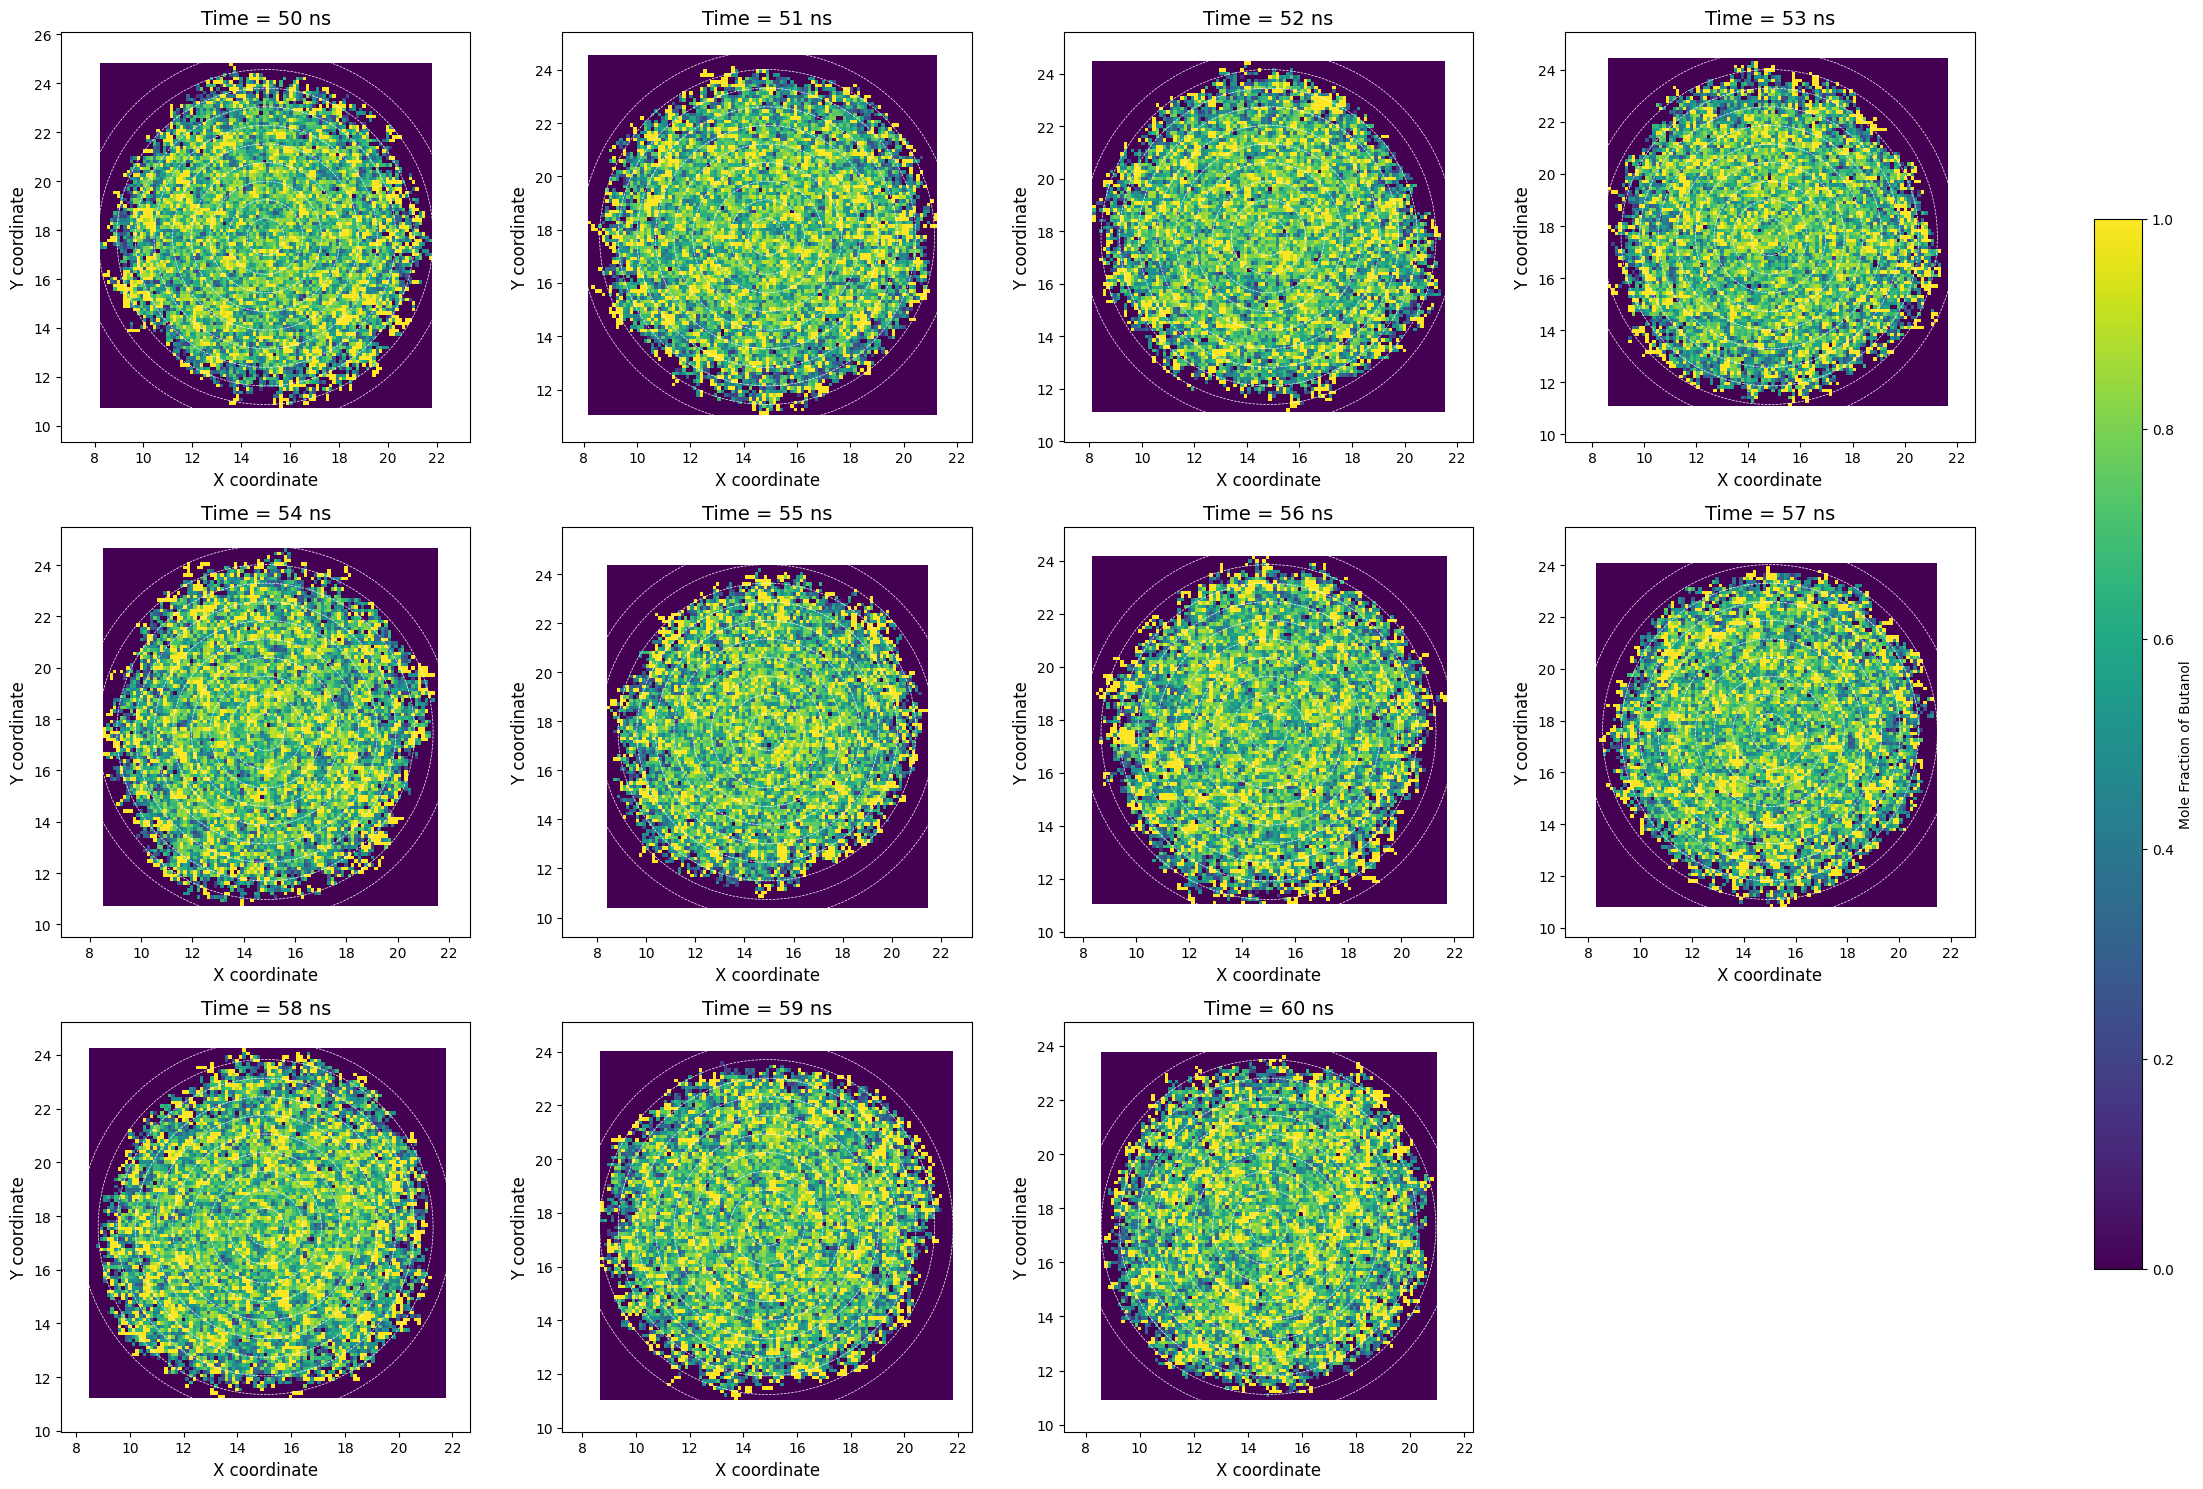

In [2]:
# ----------------------------
# Script Activation for 2D spatial heatmap - cut along Z
# ----------------------------
plot_density_heatmaps(
    trange='50-60',  # Replace with your desired time(s)
    molecule1_name='Butanol',  # Replace with actual molecule1 name
    molecule2_name='Methanol',  # Replace with actual molecule2 name
    molecule_to_plot='mol1',  # 'mol1' or 'mol2'
    num_radial_layers=10,
    save_path='./fig',  # Replace with your desired save path
    filename='density_molefrac_heatmap.png',
    bins=100,
    cmap='viridis',
    vmin=0.0,
    vmax=1.0,
    overlay_radial_bins=True,
    max_cols=4  # Number of columns in the subplot grid
)

In [3]:
# ===============================
# 2️⃣ 3D Spatial Heatmap Whole and Cross-Section
# ===============================
# 📆 Date created: October 12, 2024
# 📆 Date updated: October 14, 2024

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm  # For the loading bar

def parse_trange(trange_str):
    """
    Parse the trange string and return a list of times.

    trange can be a single time (e.g., '10'), a range (e.g., '10-20'), or multiple times (e.g., '10,11,15').
    """
    times = []
    if '-' in trange_str:
        # It's a range
        start, end = trange_str.split('-')
        times = list(range(int(start), int(end)+1))
    elif ',' in trange_str:
        # Multiple times
        times = [int(t.strip()) for t in trange_str.split(',')]
    else:
        # Single time
        times = [int(trange_str)]
    return times

def plot_density_heatmaps(
    trange='10-20',
    molecule1_name='Nonane',
    molecule2_name='Butanol',
    molecule_to_plot='mol1',  # 'mol1' or 'mol2'
    num_radial_layers=10,
    save_path='.',
    filename='density_molefrac_heatmap_3d.png',
    bins=20,  # Number of bins in x, y, and z for the heatmap
    cmap='viridis',
    vmin=0.0,
    vmax=1.0,
    overlay_radial_bins=True,
    max_cols=4,  # Max number of subplots per row
    cut_axis=None  # Add cut_axis parameter
):
    """
    Plots 3D heatmaps of x, y, z coordinates with color representing the mole fraction of the selected molecule.
    Overlays radial bins indicating radial layers.

    Parameters:
    - trange: Time range. Can be a single time (e.g., '10'), a range (e.g., '10-20'), or multiple times (e.g., '10,11,15').
    - molecule1_name: Name of molecule1.
    - molecule2_name: Name of molecule2.
    - molecule_to_plot: Which molecule's mole fraction to plot ('mol1' or 'mol2').
    - num_radial_layers: Number of radial layers to overlay.
    - save_path: Directory to save the plot.
    - filename: Name of the output plot file.
    - bins: Number of bins in x, y, and z for the heatmap.
    - cmap: Colormap to use.
    - vmin, vmax: Minimum and maximum values for the color scale.
    - overlay_radial_bins: Whether to overlay radial bins.
    - max_cols: Maximum number of subplots per row.
    - cut_axis: Axis along which to exclude molecules starting from the cluster's center of mass.
        If 'y', exclude molecules with y <= y_com (starting from center to lower y values).
        If 'x', exclude molecules with x >= x_com (starting from center to higher x values).
        If 'z', exclude molecules with z >= z_com (starting from center to higher z values).
        If None, no exclusion is applied.
    """
    # Read the per-atom data
    df_atoms = pd.read_parquet('nuc_fort-to-panda_combined.parquet')

    # Convert frame number to time
    df_atoms['time_ns'] = df_atoms['frame_number'] * 0.5

    # Parse trange
    times = parse_trange(trange)

    # For each time, get the largest cluster
    nucleus_sizes = df_atoms.groupby(['time_ns', 'nucleus_id']).size().reset_index(name='size')

    # For the specified times, get the largest nucleus
    largest_nuclei = nucleus_sizes[nucleus_sizes['time_ns'].isin(times)]
    largest_nuclei = largest_nuclei.sort_values(['time_ns', 'size'], ascending=[True, False]).drop_duplicates(['time_ns'])

    # Merge to get atoms in the largest nucleus at each time
    df_largest_nuclei = pd.merge(df_atoms, largest_nuclei[['time_ns', 'nucleus_id']], on=['time_ns', 'nucleus_id'])

    # Now, for each specified time, create a 3D heatmap
    num_times = len(times)
    num_subplots = num_times
    num_cols = min(max_cols, num_subplots)
    num_rows = (num_subplots + num_cols - 1) // num_cols

    fig = plt.figure(figsize=(6*num_cols, 5*num_rows))
    axes = []

    # Create a grid of subplots, including empty ones if necessary
    for i in range(num_rows * num_cols):
        ax = fig.add_subplot(num_rows, num_cols, i+1, projection='3d')
        axes.append(ax)

    for idx, time in enumerate(tqdm(times, desc="Processing Times")):
        ax = axes[idx]

        # Get atoms in the largest nucleus at this time
        df_time = df_largest_nuclei[df_largest_nuclei['time_ns'] == time]

        # Compute center of mass of the cluster
        x_com = df_time['x_coord'].mean()
        y_com = df_time['y_coord'].mean()
        z_com = df_time['z_coord'].mean()

        # Compute center of mass for each molecule
        df_molecule_com = df_time.groupby('molecule_id').agg({
            'x_coord': 'mean',
            'y_coord': 'mean',
            'z_coord': 'mean',
            'molecule_name': 'first'
        }).reset_index()

        print(df_molecule_com)

        # Compute distances from cluster center of mass to molecule centers of mass
        df_molecule_com['distance_to_com'] = np.sqrt(
            (df_molecule_com['x_coord'] - x_com)**2 +
            (df_molecule_com['y_coord'] - y_com)**2 +
            (df_molecule_com['z_coord'] - z_com)**2
        )

        # Exclude molecules that are more than 20 angstroms away
        df_molecule_com_filtered = df_molecule_com[df_molecule_com['distance_to_com'] <= 20.0]

        # Merge back to get atom data for filtered molecules
        df_filtered = pd.merge(df_time, df_molecule_com_filtered[['molecule_id']], on='molecule_id')

        # Apply coordinate-based exclusion based on cut_axis
        if cut_axis == 'y':
            # Exclude molecules with y <= y_com (from center up to lower y values)
            df_filtered = df_filtered[df_filtered['y_coord'] > y_com]
        elif cut_axis == 'x':
            # Exclude molecules with x >= x_com (from center up to higher x values)
            df_filtered = df_filtered[df_filtered['x_coord'] < x_com]
        elif cut_axis == 'z':
            # Exclude molecules with z >= z_com (from center up to higher z values)
            df_filtered = df_filtered[df_filtered['z_coord'] < z_com]

        # Get x, y, z coordinates
        x = df_filtered['x_coord'].values
        y = df_filtered['y_coord'].values
        z = df_filtered['z_coord'].values

        # Determine molecule1 and molecule2
        molecule_names = df_filtered['molecule_name'].unique()
        if molecule1_name in molecule_names:
            molecule1 = molecule1_name
        else:
            molecule1 = molecule_names[0]  # Use first molecule found

        if molecule2_name in molecule_names:
            molecule2 = molecule2_name
        else:
            molecule2 = molecule_names[1] if len(molecule_names) > 1 else molecule_names[0]

        # Select molecule to plot
        if molecule_to_plot == 'mol1':
            molecule_to_use = molecule1
            molecule_label = molecule1_name
        else:
            molecule_to_use = molecule2
            molecule_label = molecule2_name

        # Define the bins
        x_bins = np.linspace(x.min(), x.max(), bins+1)
        y_bins = np.linspace(y.min(), y.max(), bins+1)
        z_bins = np.linspace(z.min(), z.max(), bins+1)

        # Compute histograms for molecule_to_use and total
        H_total, edges = np.histogramdd((x, y, z), bins=(x_bins, y_bins, z_bins))

        # Select molecule_to_use atoms
        df_molecule = df_filtered[df_filtered['molecule_name'] == molecule_to_use]
        x_molecule = df_molecule['x_coord'].values
        y_molecule = df_molecule['y_coord'].values
        z_molecule = df_molecule['z_coord'].values

        H_molecule, _ = np.histogramdd((x_molecule, y_molecule, z_molecule), bins=(x_bins, y_bins, z_bins))

        # Compute mole fraction
        with np.errstate(divide='ignore', invalid='ignore'):
            mole_fraction = np.divide(H_molecule, H_total)
            mole_fraction = np.nan_to_num(mole_fraction)

        # Compute bin centers
        x_centers = (x_bins[:-1] + x_bins[1:]) / 2
        y_centers = (y_bins[:-1] + y_bins[1:]) / 2
        z_centers = (z_bins[:-1] + z_bins[1:]) / 2

        # Create meshgrid
        X, Y, Z = np.meshgrid(x_centers, y_centers, z_centers, indexing='ij')

        # Flatten the arrays
        X = X.flatten()
        Y = Y.flatten()
        Z = Z.flatten()
        Mole_fraction = mole_fraction.flatten()

        # Filter out zero mole fraction bins
        mask = Mole_fraction > 0
        X = X[mask]
        Y = Y[mask]
        Z = Z[mask]
        Mole_fraction = Mole_fraction[mask]

        # Plot using scatter
        scatter = ax.scatter(X, Y, Z, c=Mole_fraction, cmap=cmap, vmin=vmin, vmax=vmax, marker='s', s=10)

        ax.set_title(f'Time = {time} ns', fontsize=12)
        ax.set_xlabel('X coordinate', fontsize=10)
        ax.set_ylabel('Y coordinate', fontsize=10)
        ax.set_zlabel('Z coordinate', fontsize=10)

        # Adjust the viewing angle if needed
        ax.view_init(elev=20., azim=-35)

        # Overlay radial bins (spherical shells)
        if overlay_radial_bins:
            # Compute distances from center for filtered atoms
            distances = np.sqrt((x - x_com)**2 + (y - y_com)**2 + (z - z_com)**2)
            cluster_radius = distances.max()
            radial_edges = np.linspace(0, cluster_radius, num_radial_layers+1)[1:]  # Exclude zero radius

            # Plot spheres at each radial edge
            u = np.linspace(0, 2 * np.pi, 30)
            v = np.linspace(0, np.pi, 30)

            for r in radial_edges:
                xs = x_com + r * np.outer(np.cos(u), np.sin(v))
                ys = y_com + r * np.outer(np.sin(u), np.sin(v))
                zs = z_com + r * np.outer(np.ones_like(u), np.cos(v))
                ax.plot_wireframe(xs, ys, zs, color='white', linewidth=0.3, alpha=0.3)

    # Remove empty subplots
    for idx in range(num_subplots, num_rows * num_cols):
        fig.delaxes(axes[idx])

    # Add a single colorbar for the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap_instance = plt.get_cmap(cmap)
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap_instance)
    mappable.set_array([])
    fig.colorbar(mappable, cax=cbar_ax, label=f'Mole Fraction of {molecule_label}')

    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # Save the plot
    save_full_path = os.path.join(save_path, filename)
    plt.savefig(save_full_path, dpi=300)
    print(f"Plot saved to {save_full_path}")

    plt.show()

Processing Times:  38%|███▊      | 3/8 [00:00<00:00, 28.33it/s]

     molecule_id    x_coord    y_coord    z_coord molecule_name
0             10  20.907000  14.148667  32.391667           MET
1           1000  24.833667   9.416333  27.715333           MET
2          10000  21.633000  11.538667  33.400333           MET
3           1001  23.547667  13.357333  32.811167          BUTA
4           1002  21.498000  11.156333  25.249667           MET
...          ...        ...        ...        ...           ...
5481        9991  18.418333  15.670167  31.700833          BUTA
5482        9992  20.711000  13.128000  24.817667           MET
5483        9993  24.728000  10.657833  31.448833          BUTA
5484        9997  26.086167  13.269167  29.428833          BUTA
5485        9999  22.476833   8.496333  27.425000          BUTA

[5486 rows x 5 columns]
     molecule_id    x_coord    y_coord    z_coord molecule_name
0             10  21.865333  15.688667  33.413000           MET
1           1000  25.481667   9.394667  32.229333           MET
2          1000

Processing Times: 100%|██████████| 8/8 [00:00<00:00, 17.37it/s]
/tmp/ipykernel_3930/3759071515.py:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


     molecule_id    x_coord    y_coord    z_coord molecule_name
0              1  15.583667  19.874500  35.399333          BUTA
1             10  10.496333  15.704667  35.098667           MET
2            100  20.364333  16.745000  37.826667           MET
3           1000  13.874667  19.649333  30.406667           MET
4          10000  13.890667  13.853333  33.003000           MET
...          ...        ...        ...        ...           ...
8672        9993  17.082500  16.857167  32.892667          BUTA
8673        9995  10.602833  20.688833  35.107333          BUTA
8674        9997  18.084667  18.461333  33.723333          BUTA
8675        9998  19.707333  15.543667  38.996000           MET
8676        9999  11.544667  15.720167  32.934833          BUTA

[8677 rows x 5 columns]
     molecule_id    x_coord    y_coord    z_coord molecule_name
0              1  12.778333  19.955333  34.915500          BUTA
1             10  12.679667  12.528333  31.610000           MET
2            10

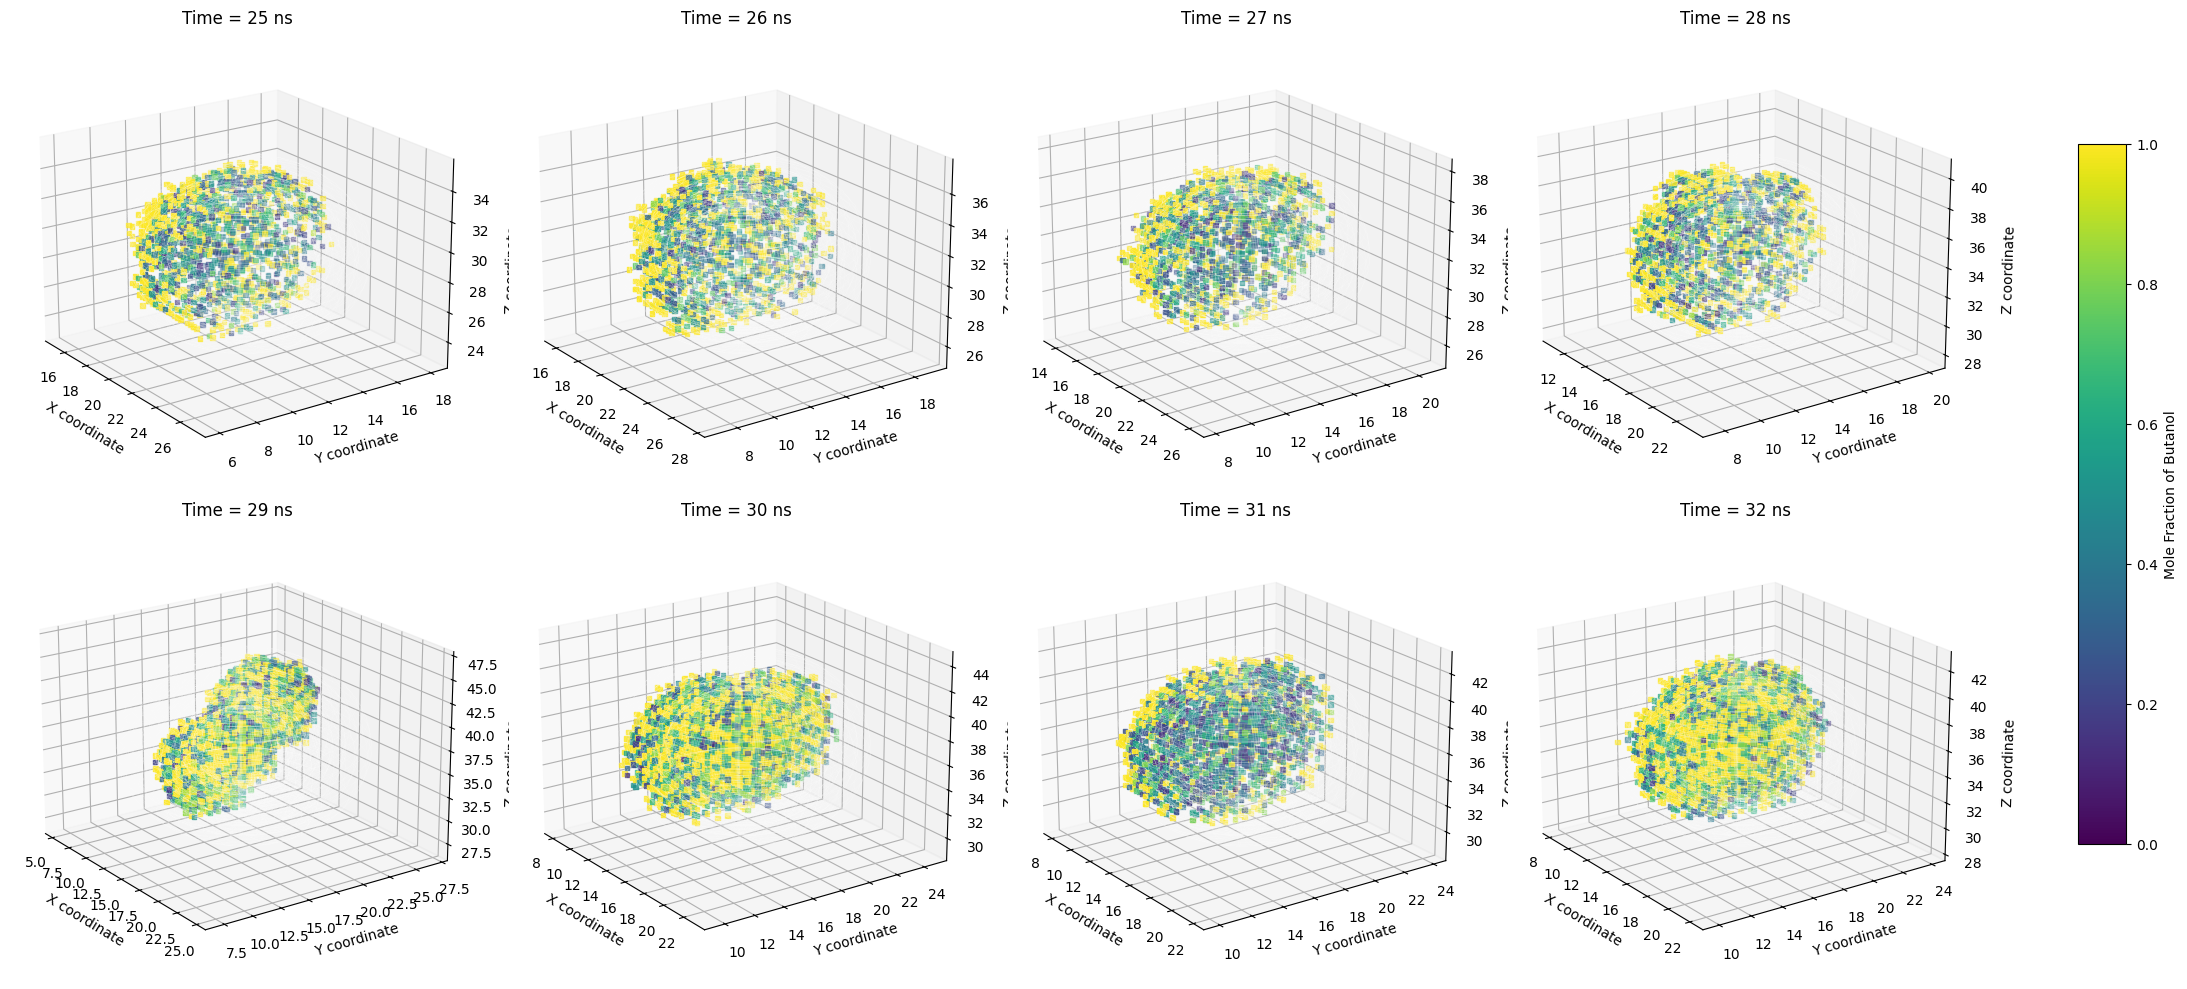

In [9]:
# ----------------------------
# Script Activation for 3D spatial heatmap - cut along x
# ----------------------------
plot_density_heatmaps(
    trange='25-32',
    molecule1_name='Butanol',
    molecule2_name='Methanol',
    molecule_to_plot='mol1',
    num_radial_layers=10,
    save_path='./fig/',
    filename='density_molefrac_heatmap_3d_cut-x.png',
    bins=20,
    cmap='viridis',
    vmin=0.0,
    vmax=1.0,
    overlay_radial_bins=True,
    max_cols=4,  # Adjust based on the number of times
    cut_axis='x'  # Specify the axis to cut
)

Processing Times:  38%|███▊      | 3/8 [00:00<00:00, 24.22it/s]

     molecule_id    x_coord    y_coord    z_coord molecule_name
0             10  20.907000  14.148667  32.391667           MET
1           1000  24.833667   9.416333  27.715333           MET
2          10000  21.633000  11.538667  33.400333           MET
3           1001  23.547667  13.357333  32.811167          BUTA
4           1002  21.498000  11.156333  25.249667           MET
...          ...        ...        ...        ...           ...
5481        9991  18.418333  15.670167  31.700833          BUTA
5482        9992  20.711000  13.128000  24.817667           MET
5483        9993  24.728000  10.657833  31.448833          BUTA
5484        9997  26.086167  13.269167  29.428833          BUTA
5485        9999  22.476833   8.496333  27.425000          BUTA

[5486 rows x 5 columns]
     molecule_id    x_coord    y_coord    z_coord molecule_name
0             10  21.865333  15.688667  33.413000           MET
1           1000  25.481667   9.394667  32.229333           MET
2          1000

Processing Times: 100%|██████████| 8/8 [00:00<00:00, 23.85it/s]

     molecule_id    x_coord    y_coord    z_coord molecule_name
0              1  15.093333  20.715833  37.295833          BUTA
1            100  19.650667  19.203000  39.207667           MET
2           1000  16.280667  17.094333  31.075333           MET
3          10000  16.855667  13.034667  33.748000           MET
4           1001  16.384333  18.768667  34.752667          BUTA
...          ...        ...        ...        ...           ...
8665        9993  18.532167  16.936167  34.060833          BUTA
8666        9995  11.619333  18.951667  36.095333          BUTA
8667        9997  18.944000  19.486667  34.503333          BUTA
8668        9998  17.795667  19.842333  40.774000           MET
8669        9999  12.039000  13.433500  35.281500          BUTA

[8670 rows x 5 columns]
     molecule_id    x_coord    y_coord    z_coord molecule_name
0              1  15.583667  19.874500  35.399333          BUTA
1             10  10.496333  15.704667  35.098667           MET
2            10


/tmp/ipykernel_3930/3759071515.py:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


Plot saved to ./fig/density_molefrac_heatmap_3d_cut-y.png


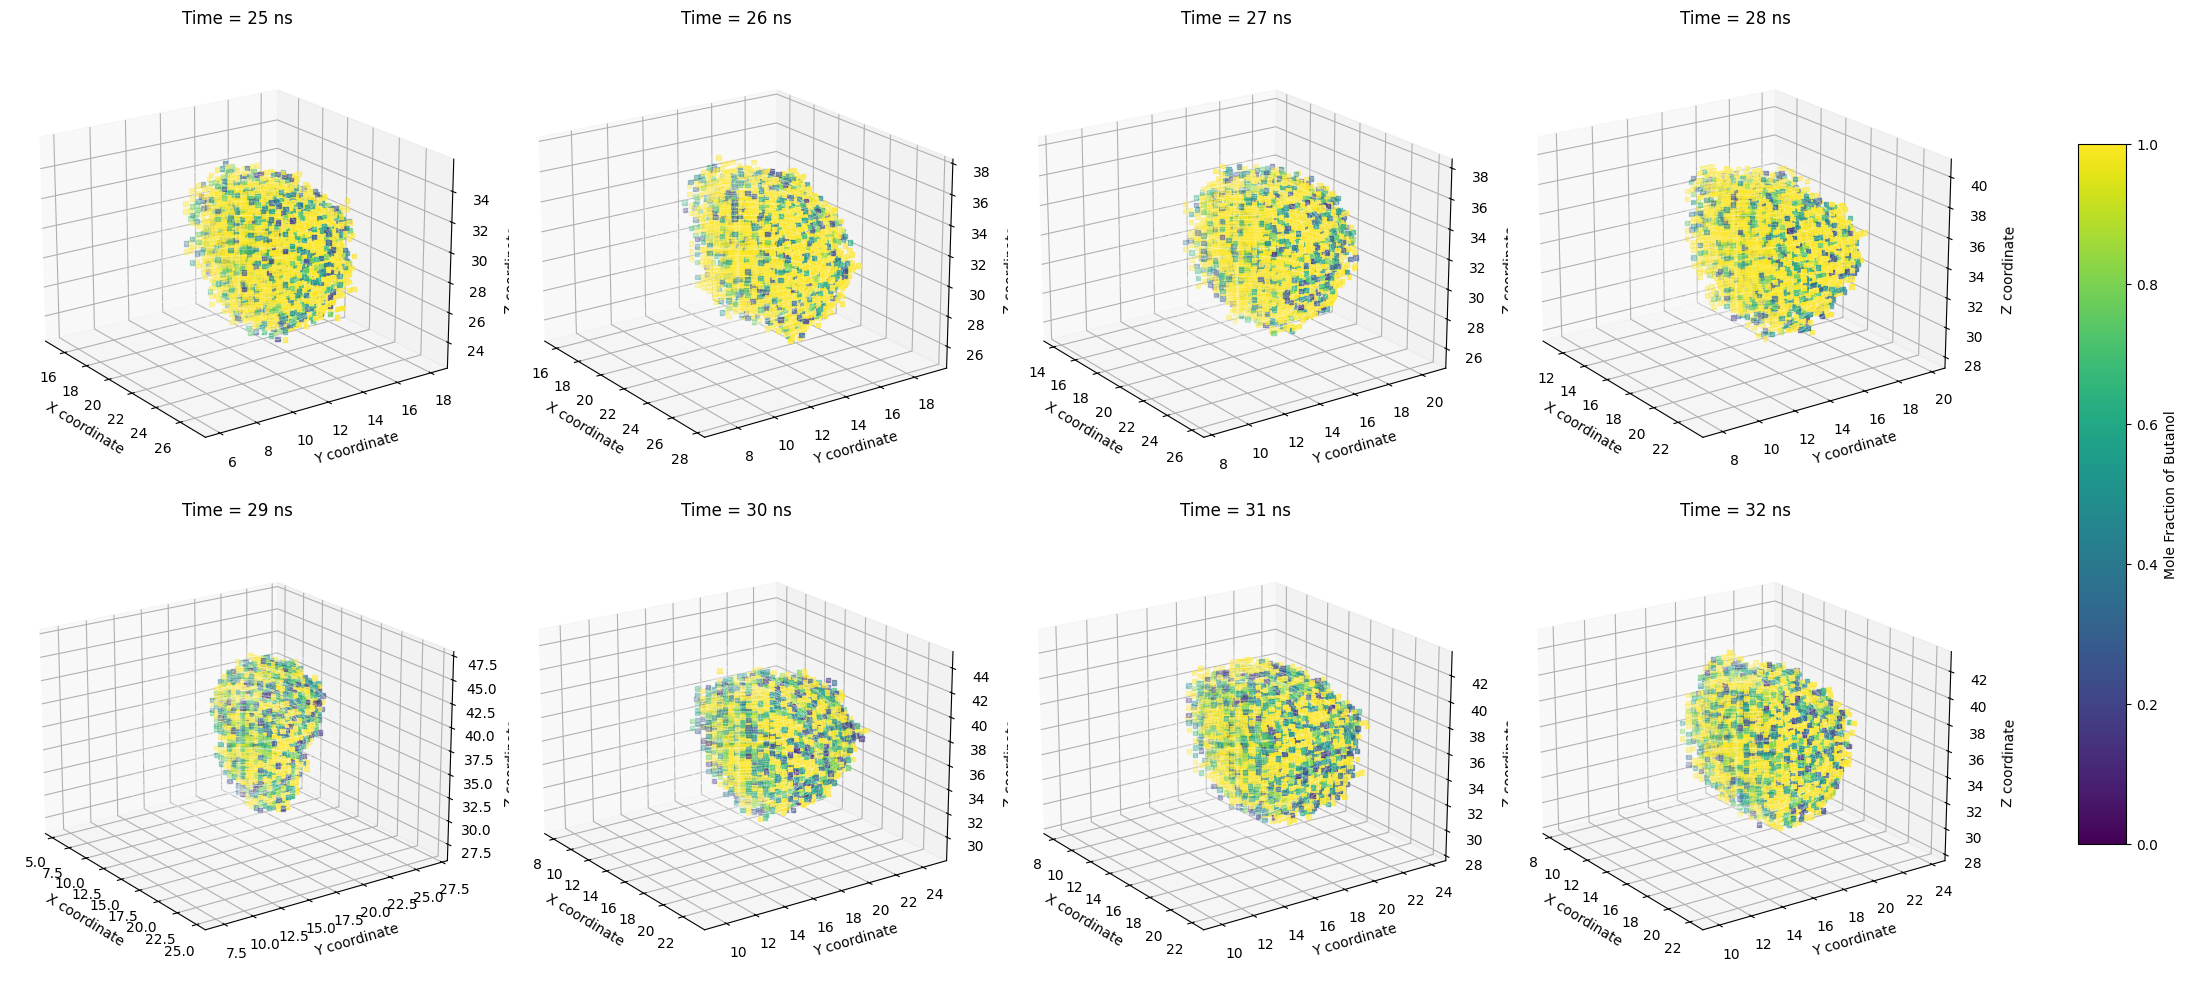

In [10]:
# ----------------------------
# Script Activation for 3D spatial heatmap - cut along y
# ----------------------------
plot_density_heatmaps(
    trange='25-32',
    molecule1_name='Butanol',
    molecule2_name='Methanol',
    molecule_to_plot='mol1',
    num_radial_layers=10,
    save_path='./fig/',
    filename='density_molefrac_heatmap_3d_cut-y.png',
    bins=20,
    cmap='viridis',
    vmin=0.0,
    vmax=1.0,
    overlay_radial_bins=True,
    max_cols=4,  # Adjust based on the number of times
    cut_axis='y'  # Specify the axis to cut
)

Processing Times:   0%|                  | 0/8 [00:00<?, ?it/s]

     molecule_id    x_coord    y_coord    z_coord molecule_name
0             10  20.907000  14.148667  32.391667           MET
1           1000  24.833667   9.416333  27.715333           MET
2          10000  21.633000  11.538667  33.400333           MET
3           1001  23.547667  13.357333  32.811167          BUTA
4           1002  21.498000  11.156333  25.249667           MET
...          ...        ...        ...        ...           ...
5481        9991  18.418333  15.670167  31.700833          BUTA
5482        9992  20.711000  13.128000  24.817667           MET
5483        9993  24.728000  10.657833  31.448833          BUTA
5484        9997  26.086167  13.269167  29.428833          BUTA
5485        9999  22.476833   8.496333  27.425000          BUTA

[5486 rows x 5 columns]
     molecule_id    x_coord    y_coord    z_coord molecule_name
0             10  21.865333  15.688667  33.413000           MET
1           1000  25.481667   9.394667  32.229333           MET
2          1000

Processing Times:  62%|██████▎   | 5/8 [00:00<00:00, 12.55it/s]

     molecule_id    x_coord    y_coord    z_coord molecule_name
0             10  21.410667  15.108667  36.086000           MET
1           1000  17.918667  17.828000  30.983000           MET
2          10000  20.157333  12.980667  34.058333           MET
3           1001  18.922833  18.484500  33.113667          BUTA
4           1002  12.531667  13.514667  32.357000           MET
...          ...        ...        ...        ...           ...
5530        9991  20.965667  11.652667  36.162167          BUTA
5531        9992  14.222667  10.445667  36.713333           MET
5532        9993  19.595333  16.088333  34.060000          BUTA
5533        9997  19.886833  17.801667  35.804833          BUTA
5534        9999  16.222000  13.442000  30.024333          BUTA

[5535 rows x 5 columns]
     molecule_id    x_coord    y_coord    z_coord molecule_name
0              1  13.027667  19.771333  39.728833          BUTA
1             10  21.170000  15.563667  35.034333           MET
2            10

Processing Times: 100%|██████████| 8/8 [00:00<00:00, 14.57it/s]
/tmp/ipykernel_3930/3759071515.py:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


Plot saved to ./fig/density_molefrac_heatmap_3d_cut-z.png


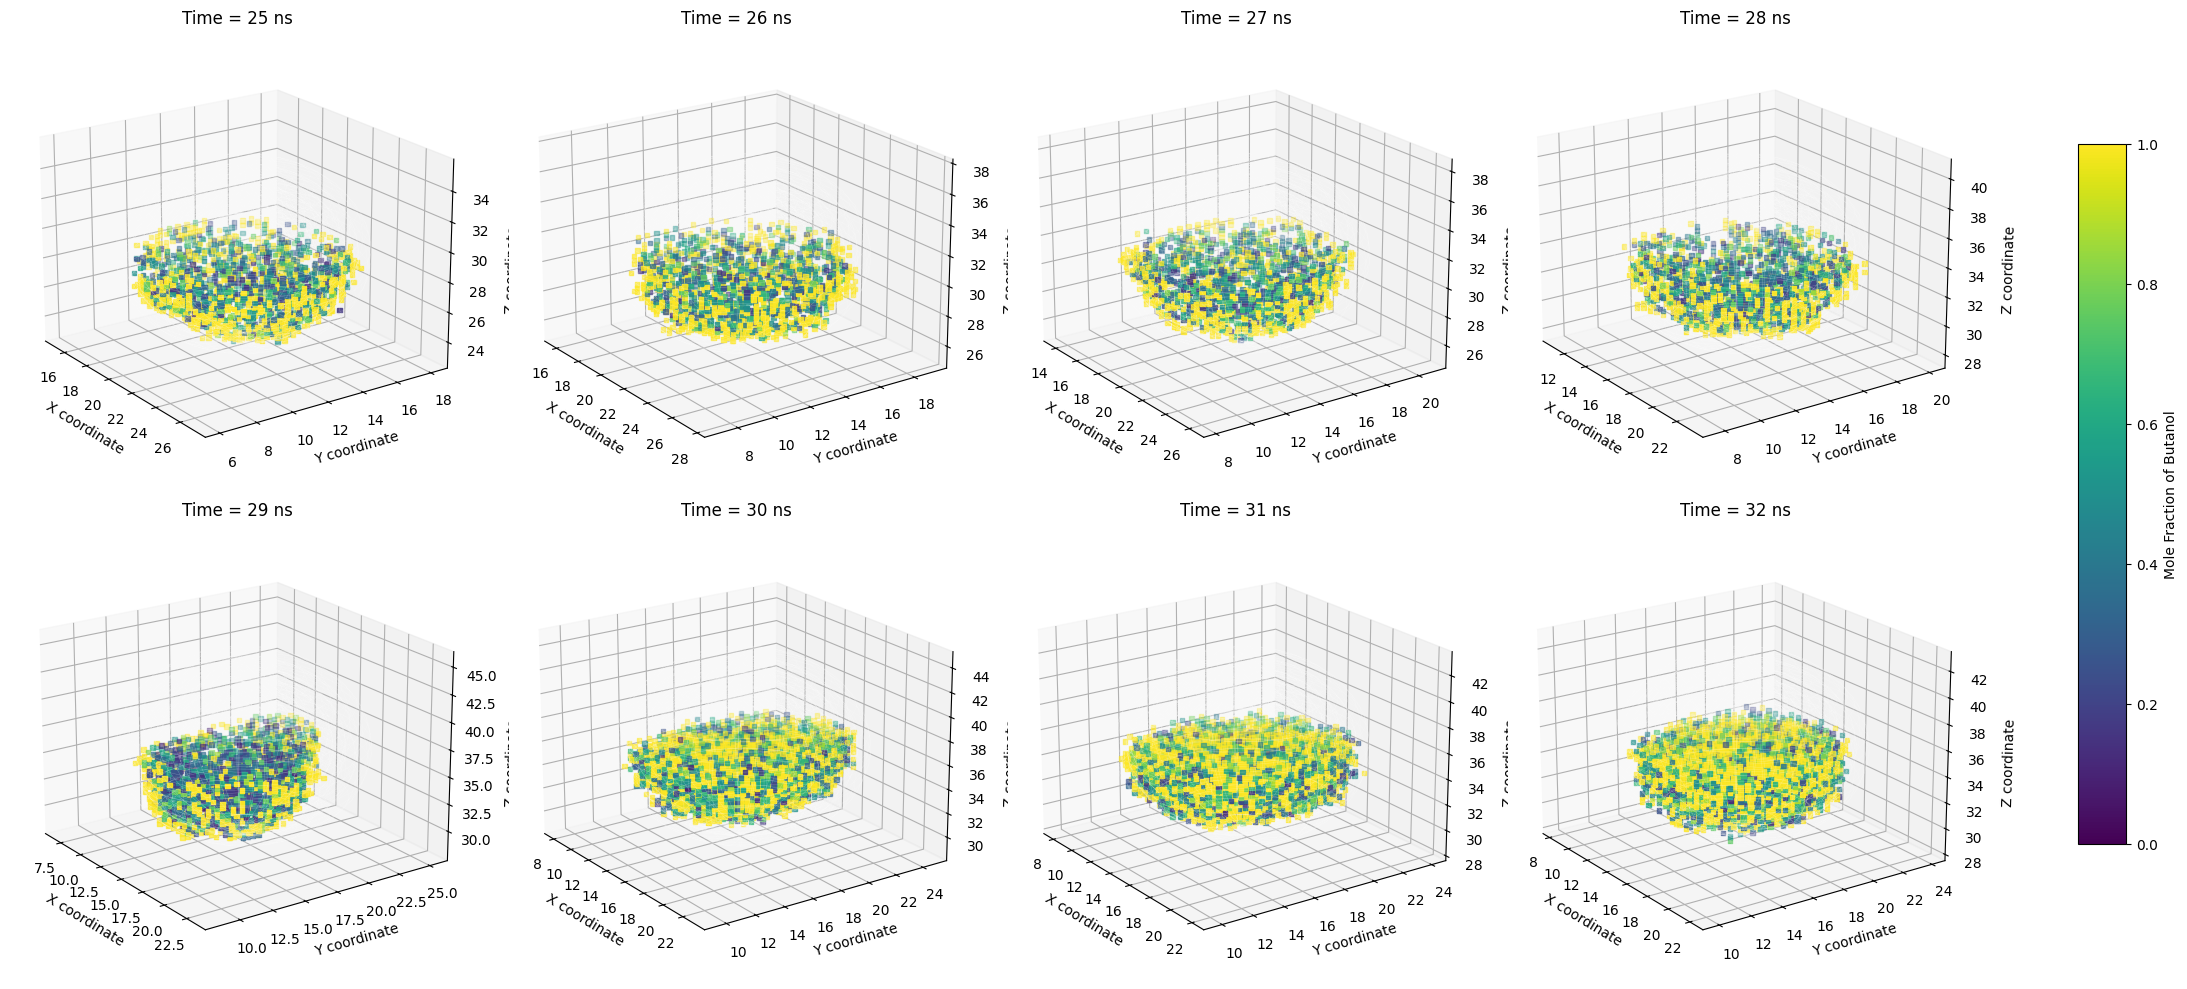

In [13]:
# ----------------------------
# Script Activation for 3D spatial heatmap - cut along z
# ----------------------------
plot_density_heatmaps(
    trange='25-32',
    molecule1_name='Butanol',
    molecule2_name='Methanol',
    molecule_to_plot='mol1',
    num_radial_layers=10,
    save_path='./fig/',
    filename='density_molefrac_heatmap_3d_cut-z.png',
    bins=20,
    cmap='viridis',
    vmin=0.0,
    vmax=1.0,
    overlay_radial_bins=True,
    max_cols=4,  # Adjust based on the number of times
    cut_axis='z'  # Specify the axis to cut
)

Processing Times:  50%|█████     | 4/8 [00:00<00:00, 31.24it/s]

     molecule_id    x_coord    y_coord    z_coord molecule_name
0             10  20.907000  14.148667  32.391667           MET
1           1000  24.833667   9.416333  27.715333           MET
2          10000  21.633000  11.538667  33.400333           MET
3           1001  23.547667  13.357333  32.811167          BUTA
4           1002  21.498000  11.156333  25.249667           MET
...          ...        ...        ...        ...           ...
5481        9991  18.418333  15.670167  31.700833          BUTA
5482        9992  20.711000  13.128000  24.817667           MET
5483        9993  24.728000  10.657833  31.448833          BUTA
5484        9997  26.086167  13.269167  29.428833          BUTA
5485        9999  22.476833   8.496333  27.425000          BUTA

[5486 rows x 5 columns]
     molecule_id    x_coord    y_coord    z_coord molecule_name
0             10  21.865333  15.688667  33.413000           MET
1           1000  25.481667   9.394667  32.229333           MET
2          1000

Processing Times: 100%|██████████| 8/8 [00:00<00:00, 26.29it/s]
/tmp/ipykernel_3930/3759071515.py:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


     molecule_id    x_coord    y_coord    z_coord molecule_name
0              1  15.583667  19.874500  35.399333          BUTA
1             10  10.496333  15.704667  35.098667           MET
2            100  20.364333  16.745000  37.826667           MET
3           1000  13.874667  19.649333  30.406667           MET
4          10000  13.890667  13.853333  33.003000           MET
...          ...        ...        ...        ...           ...
8672        9993  17.082500  16.857167  32.892667          BUTA
8673        9995  10.602833  20.688833  35.107333          BUTA
8674        9997  18.084667  18.461333  33.723333          BUTA
8675        9998  19.707333  15.543667  38.996000           MET
8676        9999  11.544667  15.720167  32.934833          BUTA

[8677 rows x 5 columns]
     molecule_id    x_coord    y_coord    z_coord molecule_name
0              1  12.778333  19.955333  34.915500          BUTA
1             10  12.679667  12.528333  31.610000           MET
2            10

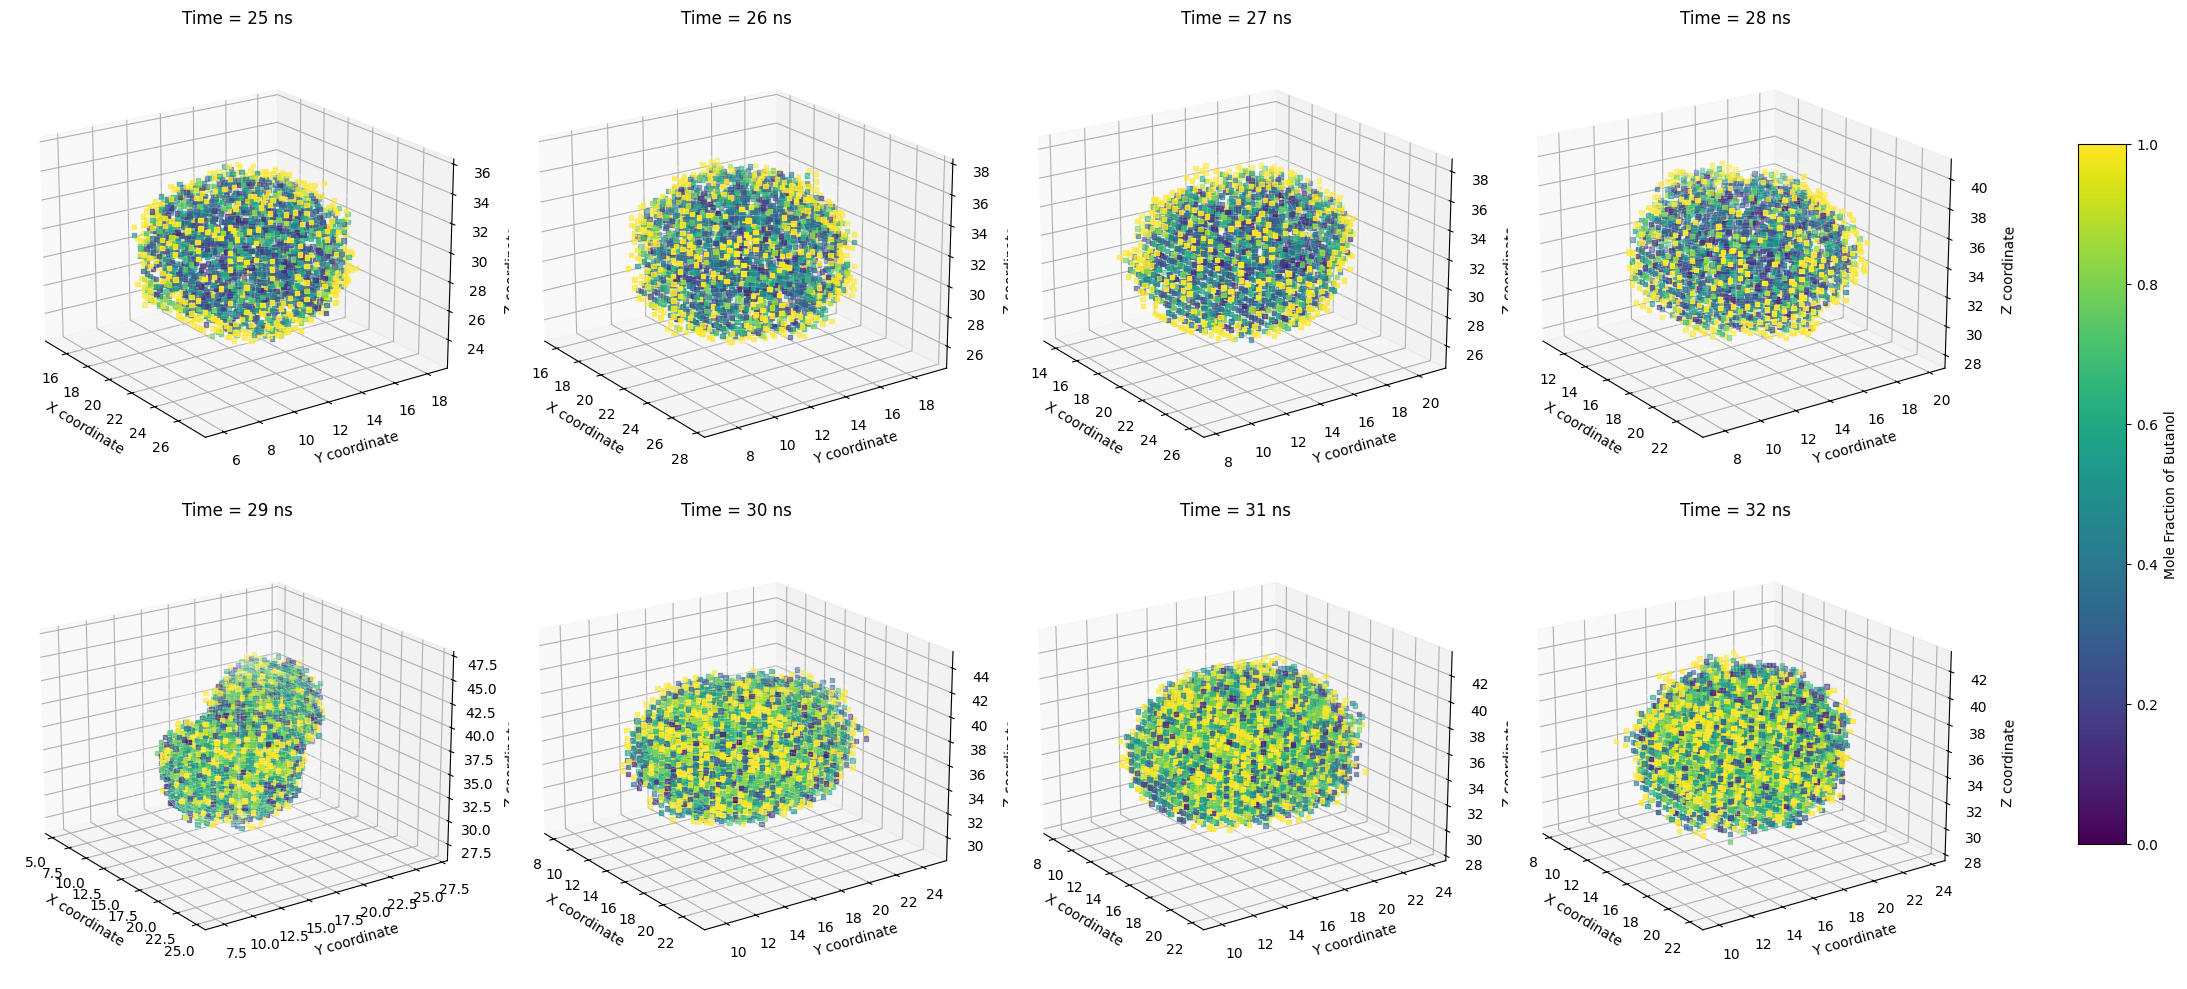

In [12]:
# ----------------------------
# Script Activation for 3D spatial heatmap - no cut
# ----------------------------
plot_density_heatmaps(
    trange='25-32',
    molecule1_name='Butanol',
    molecule2_name='Methanol',
    molecule_to_plot='mol1',
    num_radial_layers=10,
    save_path='./fig/',
    filename='density_molefrac_heatmap_3d_nocut.png',
    bins=20,
    cmap='viridis',
    vmin=0.0,
    vmax=1.0,
    overlay_radial_bins=True,
    max_cols=4,  # Adjust based on the number of times
    cut_axis=None  # Specify the axis to cut
)